In [1]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from PIL import Image
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:
# Paths
DATA_PATH = "HAM10000"
IMAGE_PATH = os.path.join(DATA_PATH, "images")
METADATA_PATH = os.path.join(DATA_PATH, "HAM10000_metadata.csv")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# Load metadata
metadata = pd.read_csv(METADATA_PATH)
metadata.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


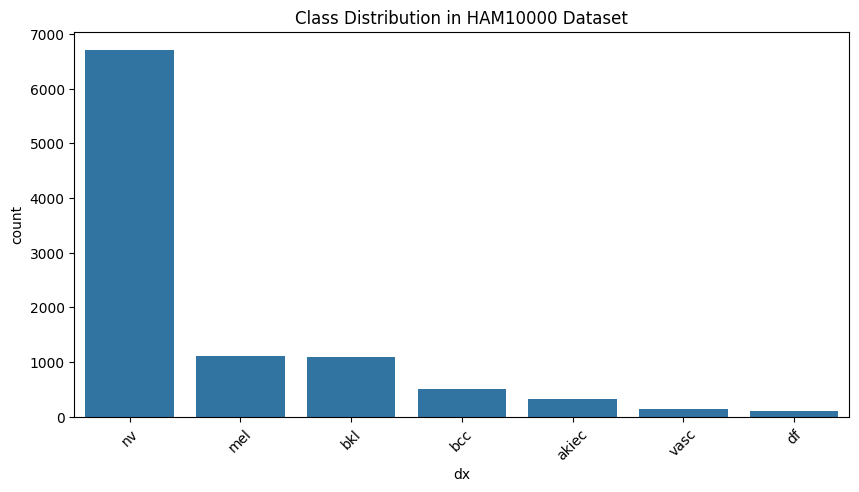

In [4]:
# Class distribution
plt.figure(figsize=(10,5))
sns.countplot(x='dx', data=metadata, order=metadata['dx'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Class Distribution in HAM10000 Dataset")
plt.show()


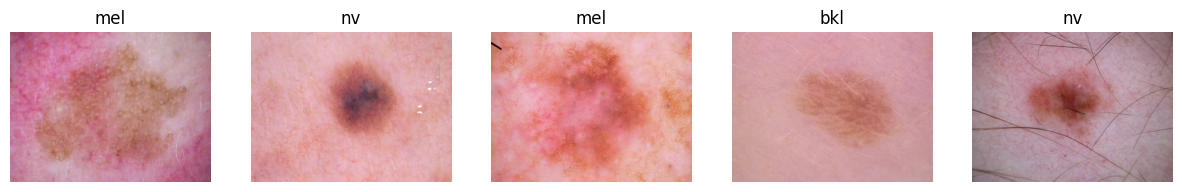

In [5]:
# Display some sample images
sample_images = metadata.sample(5)
plt.figure(figsize=(15,5))
for i, row in enumerate(sample_images.itertuples()):
    image_path = os.path.join(IMAGE_PATH, row.image_id + ".jpg")
    img = Image.open(image_path).convert("RGB")
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(row.dx)
    plt.axis('off')
plt.show()


In [6]:
# Image Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


In [7]:
# Custom Dataset Class
class SkinCancerDataset(Dataset):
    def __init__(self, image_dir, metadata, transform=None):
        self.image_dir = image_dir
        self.metadata = metadata
        self.transform = transform
        self.image_ids = metadata["image_id"].values
        self.labels = metadata["dx"].values
        self.label_map = {label: idx for idx, label in enumerate(np.unique(self.labels))}
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        label = self.labels[idx]
        label_idx = self.label_map[label]
        image_path = os.path.join(self.image_dir, image_id + ".jpg")
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label_idx, image_id

# Load dataset
dataset = SkinCancerDataset(IMAGE_PATH, metadata, transform)


In [8]:
# Subset for quick testing
subset_size = 10015
dataset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])

# Train/Test Split
train_size = int(0.8 * subset_size)
test_size = subset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [9]:
# Handle class imbalance safely
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Helper function to unwrap Subset objects
def get_original_dataset(subset):
    """Recursively unwrap Subset objects to get the original dataset."""
    while isinstance(subset, torch.utils.data.Subset):
        subset = subset.dataset
    return subset

# Get the original SkinCancerDataset
original_dataset = get_original_dataset(train_dataset)

# Get labels for the train subset without loading images
train_labels = [original_dataset.labels[idx] for idx in train_dataset.indices]

# Compute class counts and weights
class_counts = Counter(train_labels)
class_weights = {k: 1.0 / v for k, v in class_counts.items()}

# Assign sample weights for the sampler
sample_weights = [class_weights[label] for label in train_labels]

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

print("Class counts:", class_counts)
print("Sample weights assigned for WeightedRandomSampler.")


Class counts: Counter({'nv': 5398, 'mel': 876, 'bkl': 868, 'bcc': 413, 'akiec': 256, 'vasc': 115, 'df': 86})
Sample weights assigned for WeightedRandomSampler.


In [10]:
# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# Pretrained ResNet Model
class SkinCancerResNet(nn.Module):
    def __init__(self, num_classes):
        super(SkinCancerResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    def forward(self, x):
        return self.resnet(x)

num_classes = len(metadata["dx"].unique())
model = SkinCancerResNet(num_classes).to(device)


d:\skin_risk_ai\ml_model\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\skin_risk_ai\ml_model\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Loss and optimizer
class_weights_tensor = torch.tensor(list(class_weights.values())).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [13]:
from tqdm.notebook import tqdm

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Wrap the loader with tqdm
        loop = tqdm(train_loader, leave=False)
        for images, labels, _ in loop:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar dynamically
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item(), acc=correct/total)

        # Epoch summary
        epoch_acc = correct / total
        epoch_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")


In [14]:
# Test function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions, actuals, image_ids = [], [], []
    with torch.no_grad():
        for images, labels, img_ids in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            image_ids.extend(img_ids)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy, predictions, actuals, image_ids


In [16]:
# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)

# Save model
torch.save(model.state_dict(), "skin_cancer_model.pth")
print("Model state saved.")

  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 0.2628 | Accuracy: 0.7378


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 0.2061 | Accuracy: 0.7698


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 0.2045 | Accuracy: 0.7743


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 0.1771 | Accuracy: 0.7992


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 0.1746 | Accuracy: 0.8048


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 0.1634 | Accuracy: 0.8188


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 0.1551 | Accuracy: 0.8233


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 0.1482 | Accuracy: 0.8315


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 0.1317 | Accuracy: 0.8508


  0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 0.1328 | Accuracy: 0.8497
Model state saved.


In [17]:
# Evaluate model
accuracy, predictions, actuals, image_ids = test_model(model, test_loader)
print(f"Test Accuracy: {accuracy:.4f}")

# Convert predictions to labels
label_map = {v: k for k, v in dataset.dataset.label_map.items()}
predicted_labels = [label_map[p] for p in predictions]
actual_labels = [label_map[a] for a in actuals]

# Save predictions to CSV
output_df = pd.DataFrame({
    "image_id": image_ids,
    "actual_label": actual_labels,
    "predicted_label": predicted_labels
})
output_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")

Test Accuracy: 0.7743
Predictions saved to predictions.csv


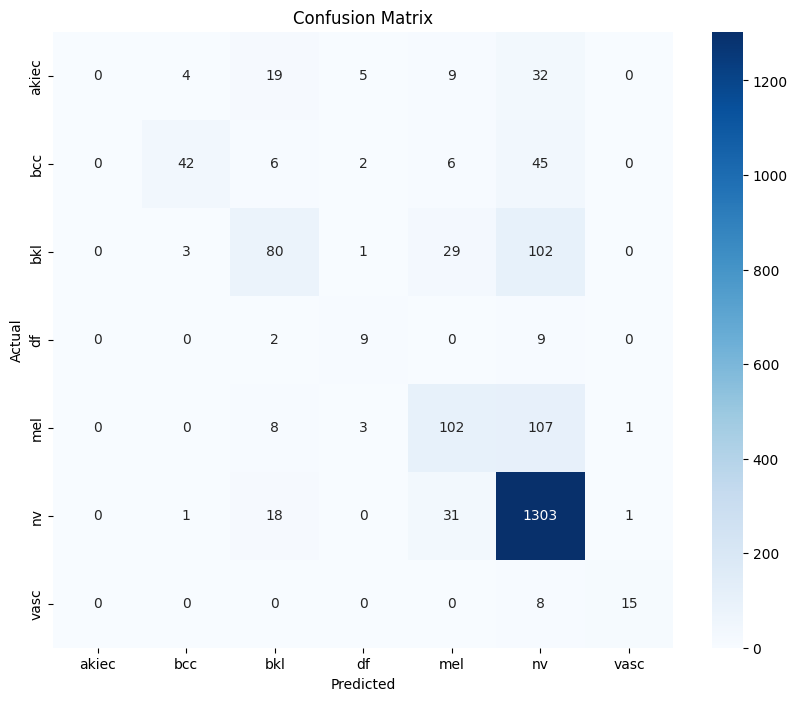

In [18]:
# Plot confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=list(label_map.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_map.values(), yticklabels=label_map.values(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# Classification report (identify classes with poor performance)
print("Classification Report:\n")
print(classification_report(actual_labels, predicted_labels, target_names=list(label_map.values())))


Classification Report:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        69
         bcc       0.84      0.42      0.56       101
         bkl       0.60      0.37      0.46       215
          df       0.45      0.45      0.45        20
         mel       0.58      0.46      0.51       221
          nv       0.81      0.96      0.88      1354
        vasc       0.88      0.65      0.75        23

    accuracy                           0.77      2003
   macro avg       0.59      0.47      0.52      2003
weighted avg       0.73      0.77      0.74      2003



d:\skin_risk_ai\ml_model\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\skin_risk_ai\ml_model\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\skin_risk_ai\ml_model\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


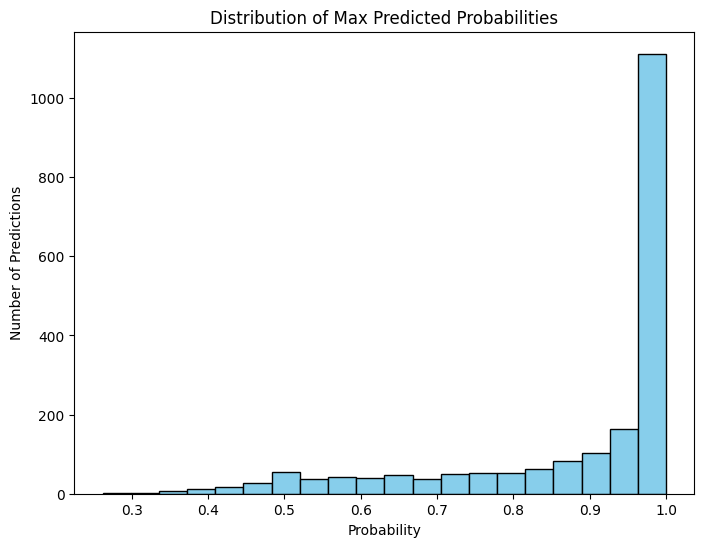

In [20]:
# Analyze model confidence and overconfidence in wrong predictions
# Collect probabilities
probabilities = []
model.eval()
with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(device)
        outputs = torch.nn.functional.softmax(model(images), dim=1)
        probabilities.extend(outputs.cpu().numpy())

# Histogram of maximum predicted probabilities
max_probs = [max(p) for p in probabilities]
plt.figure(figsize=(8, 6))
plt.hist(max_probs, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Max Predicted Probabilities")
plt.xlabel("Probability")
plt.ylabel("Number of Predictions")
plt.show()


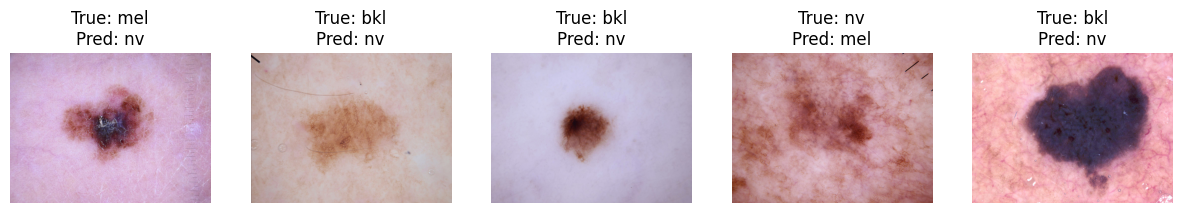

In [21]:
# Show misclassified images
misclassified_idx = [i for i, (a, p) in enumerate(zip(actual_labels, predicted_labels)) if a != p]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_idx[:5]):  # first 5 misclassified
    img_path = os.path.join(IMAGE_PATH, image_ids[idx] + ".jpg")
    img = Image.open(img_path).convert("RGB")
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {actual_labels[idx]}\nPred: {predicted_labels[idx]}")
    plt.axis("off")
plt.show()
